# Programming Assignment II: a Multi-Qubit Swap Test with Qiskit

This assignment aims to implement a multi-qubit quantum circuit using Qiskit to compare two three-qubit quantum systems, one selected randomly and one given.

You will be comparing a randomly generated quantum state between |0⟩ and |7⟩ with another quantum system in state |5⟩ using the Swap Test. Such a simple algorithm can recognize a particular state from a data stream encoded in qubits. For instance, the basic functioning method can be used in quantum machine learning for anomaly detection.

The assignment consists of two parts.

## Part 1: Comparing Two Three-Qubit Systems

### Task 1.1 - Design and implement the multi-qubit Swap Test

- QS1: Random Quantum State Generation
    + Generate a random quantum state for the first three-qubit system. This state should consist of a single randomly selected basis state from |0⟩ to |7⟩. You can use Python random number generation functions to choose the state. This quantum system will not be in superposition but one of the eight basis states.

- QS2: Quantum State |5⟩ Generation
    + Multi-qubit Swap Test: Design and create a quantum circuit in Qiskit that implements the Swap Test to compare the two three-qubit systems: the randomly generated state from QS1 and |5⟩ (QS2).
    + Remember that different design solutions are possible, and you can pick the one you come with. Please comment on your design solution, providing some rationale.

### Task 1.2- Measurement and Evaluation.

- Simulate the quantum circuit using Qiskit Aer's quantum simulator.
    + Measure the final state of the circuit and determine whether the first three-qubit system is equal to |5⟩ or not.

- Analyze the results obtained.
    + Calculate the accuracy of your quantum circuit in correctly identifying whether the first quantum system is equal to |5⟩.
    + Discuss any cases where the identification is incorrect or when ~~|7⟩~~ |5⟩ is not correctly identified.

## Part 2: Introducing Superposition in the State Chosen Randomly

### Task 2.1 - Superposition of a Qubit

- Modify the quantum circuit from Part 1 by putting one of the qubits of the randomly generated quantum state into superposition. You can use Hadamard gates for this purpose.

### Task 2.2 Measurement and Evaluation (Superposition) and Analysis

- Simulate the modified quantum circuit with the qubit in superposition using Qiskit Aer.
    + Measure the final state and determine whether the first quantum system (with a qubit in superposition) is equal to |5⟩.

- Accuracy Analysis (Superposition):
    + Compare the accuracy results from Part 1 with the modified circuit in Part 2.
    + Comment on how introducing superposition affects the accuracy of the comparison and whether it improves or worsens the identification of |5⟩.

## Assignment Report

In your report, please provide:
1. A brief description of the quantum circuit design, including the gates used and their sequence.
2. Code implementation of the quantum circuit using Qiskit.
3. simulation results, including accuracy measurements and any observations regarding incorrect identification.
4. An analysis of the impact of introducing superposition on the accuracy of the comparison.

In [46]:
import numpy as np
from numpy.random import randint
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector

from my_quantum_circuit import MyQuantumCircuit

In [48]:
IBMQ_API_TOKEN: str = '2ebc90b4f6a0a95f7af6e953a4481652c258639d9a23ff2e3531024fd977e39910b05cfb58d76ead4ef7f662177156753f13c265522a70a8fb208d3a11913039'
IBMQ.save_account(IBMQ_API_TOKEN)
IBMQ.load_account()
pass

configrc.store_credentials:WARNING:2023-10-31 22:59:24,037: Credentials already present. Set overwrite=True to overwrite.


In [195]:
class SwapTestQuantumCircuit(MyQuantumCircuit):

    def swap_test(
            self,
            qreg_1_index: int,
            qreg_2_index: int,
            qreg_ancillary_index: int,
            qreg_output_index: int
    ):
        c = self.circuit
        qreg_1 = c.qregs[qreg_1_index]
        qreg_2 = c.qregs[qreg_2_index]
        qreg_ancillary = c.qregs[qreg_ancillary_index]
        qreg_output = c.qregs[qreg_output_index]

        assert qreg_1.size == qreg_2.size == qreg_ancillary.size
        n_qubits = qreg_1.size

        c.h(qreg_output)
        #
        c.barrier()
        for j in range(n_qubits):
            c.cx(control_qubit=qreg_1[j], target_qubit=qreg_ancillary[j])
            c.cx(control_qubit=qreg_2[j], target_qubit=qreg_ancillary[j])
            c.ch(control_qubit=qreg_ancillary[j], target_qubit=qreg_1[j])

            c.cswap(control_qubit=qreg_output[0], target_qubit1=qreg_1[j], target_qubit2=qreg_2[j])
            c.barrier()
        #
        c.h(qreg_output)
        c.x(qreg_output)

        return self

    def get_similarity(self, n_qubits: int):
        counts = self.result.get_counts()
        counts.setdefault('0', 0)
        counts.setdefault('1', 0)

        total = counts['0'] + counts['1']
        diff = counts['1'] - counts['0']
        ratio = diff / total
        exp2 = - np.log2(ratio)
        similarity = (n_qubits - exp2) / n_qubits
        similarity = max(0.0, min(1.0, similarity))
        similarity = f'{np.floor(similarity * 10_000) / 100}%'
        return self, similarity

Input 1 (random state):   |4⟩
Input 2 (fixed state):    |5⟩
-----------------------------
Similarity(|4⟩, |5⟩) = 64.16%


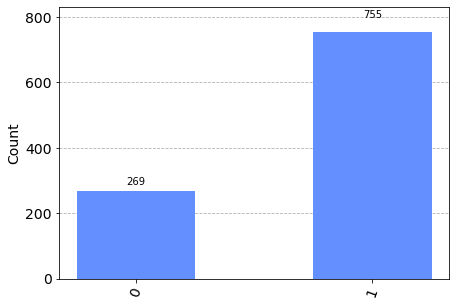

In [204]:

N_QUBITS = 3
RANDOM_STATE = np.random.randint(0, 2 ** N_QUBITS)  # Initialize qreg_1 to a state randomly picked between |0> and |7>
FIXED_STATE = 5  # Initialize qreg_2 to state |5>

# Create registers
qregs = [
    QuantumRegister(N_QUBITS, 'input_1_quantum_register'),
    QuantumRegister(N_QUBITS, 'input_2_quantum_register'),
    QuantumRegister(N_QUBITS, 'ancillary_quantum_register'),
    QuantumRegister(1, 'output_quantum_register'),
]

cregs = [ClassicalRegister(1, 'output_classical_register')]

my_circuit = SwapTestQuantumCircuit()

_, plotted_results = my_circuit\
    .create_circuit(qregs=qregs, cregs=cregs)\
    .prepare_qreg_step(qreg_index=0, init_val=RANDOM_STATE)\
    .prepare_qreg_step(qreg_index=1, init_val=FIXED_STATE)\
    .swap_test(qreg_1_index=0, qreg_2_index=1, qreg_ancillary_index=2, qreg_output_index=3)\
    .measure_qreg_to_creg(3, 0)\
    .execute_circuit()\
    .plot_results()

_, similarity = my_circuit.get_similarity(n_qubits=N_QUBITS)


# 5 vs 2        | 0.4375   | 0.5625    | 0.125  = 1 / 2^3   | 0%        = 1/3 * (3 - 3) |
# 5 vs. 0, 3, 6 | 0.375    | 0.625     | 0.25   = 1 / 2^2   | 33.33%    = 1/3 * (3 - 2) |
# 5 vs. 1, 7, 4 | 0.25     | 0.75      | 0.5    = 1 / 2^1   | 66.67%    = 1/3 * (3 - 1) |
# 5 vs. 5       | 0.0      | 1.0       | 1.0    = 1 / 2^0   | 100%      = 1/3 * (3 - 0) |

# 2 vs. 1       | 0.375 | 0.625 | 0.25  = 1 / 2^2   | 0%     = 1/2 * (2 - 2) |
# 2 vs. 0, 3    | 0.25  | 0.75  | 0.5   = 1 / 2^1   | 50%    = 1/2 * (2 - 1) |
# 2 vs. 2       | 0.0   | 1.0   | 1.0   = 1 / 2^0   | 100%   = 1/2 * (2 - 0) |
print(
    f'Input 1 (random state):   |{RANDOM_STATE}⟩\n'
    f'Input 2 (fixed state):    |{FIXED_STATE}⟩'
)
print('-----------------------------')
print(f'Similarity(|{RANDOM_STATE}⟩, |{FIXED_STATE}⟩) = {similarity}')
plotted_results

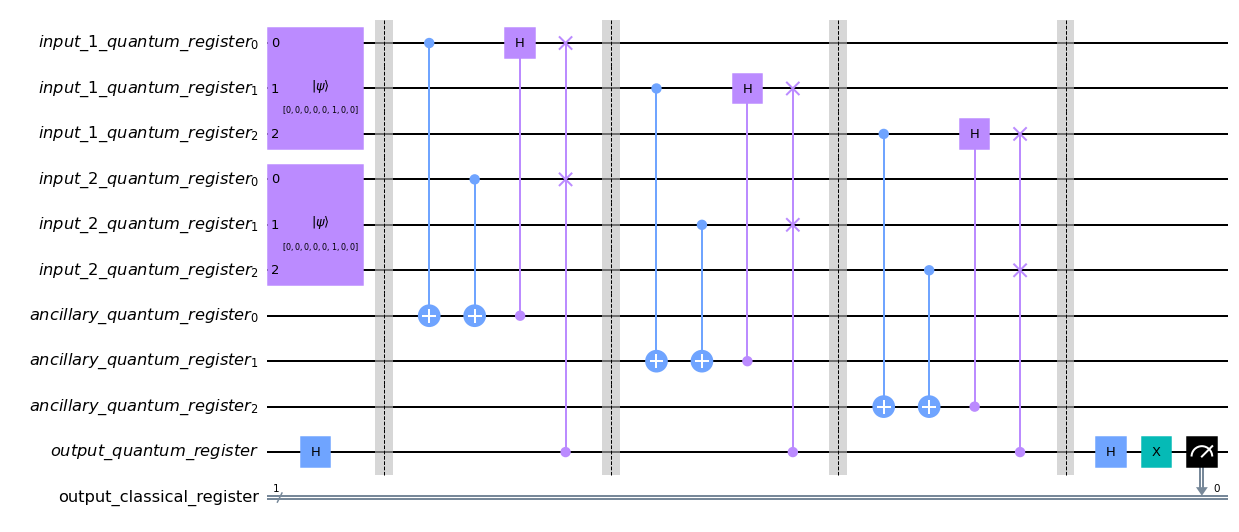

In [176]:
my_circuit.circuit.draw('mpl')